$
\begin{align}
&P(L=l, R=r, V=v, H=h)= \\
&=\begin{cases}
       \sum_{i\in \text{no coal}} & \text{if $l=r$ and $v=h$}\\
    \end{cases}       
\end{align}
$

In [124]:
from IPython.display import SVG
import numpy as np
import pandas as pd
from scipy.linalg import expm
import itertools
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [2]:
def recombination(i):
    """
    This function returns all possible states after a 
    single recombination event given an initial state
    """
    # Create empty list
    new_lst = []
    # For each block index in the list
    for block in range(len(i)):
        # If the site is linked
        if 0 not in i[block]:
            # Remove block
            lst = i[:block]+i[block+1:]
            # Split block
            lst = lst + [(i[block][0], 0), (0, i[block][1])]
            # Append to list
            new_lst.append(sorted(lst))
    return new_lst

In [3]:
def coalescent(i):
    """
    This function returns all possible states after a 
    single coalescence event given an initial state. 
    The returned list is somewhat ordered, so that the 
    first states correspond to reversible coalescence 
    events, and the last to non-reversible ones.
    """
    # Get unique values per site
    n_0 = set([0]+list(sum(i, ())))
    reversible = []
    nonreversible = []
    # For each combination of blocks
    for b1 in range(len(i)):
        for b2 in range(b1+1, len(i)):
            # Create new block by merging
            add_lst = [(i[b1][0]+i[b2][0], i[b1][1]+i[b2][1])]
            # For each index in i
            for b3 in range(len(i)):
                # If the index is not in among the merged blocks
                if b3 not in [b1, b2]:
                    # Append to list
                    add_lst.append(i[b3])
            # If the unique values are different from the 
            # original block
            if set([0]+list(sum(add_lst, ()))) == n_0:
                # Append to reversible coalescence list
                reversible.append(sorted(add_lst))
            else:
                # Append to non-reversible coalescence list
                nonreversible.append(sorted(add_lst))
    l = reversible+nonreversible
    return l

In [4]:

def idx(i):
    j = list(sum(i, ()))
    return -(len(j)-j.count(0))

def get_states(lst):
    """
    Given a list of states, this function finds all possible
    recombination and coalescence states iteratively.
    """
    # Sort block per states just in case
    all_states = [sorted(i) for i in lst]
    # Define pool of states to be transformed
    state_pool = all_states
    # While the pool is non-empty
    while len(state_pool) > 0:
        # Define result list per iteration
        iter_states = []
        # For each of the states in the pool
        for i in state_pool:
            # Save coalescent transformation
            iter_states = iter_states+coalescent(i)
            # Save recombination transformation
            iter_states = iter_states+recombination(i)
        # Keep unique values in the original order
        iter_states = sorted(list(list(i) for i in set(tuple(row) for row in iter_states)), key = iter_states.index)
        # Define pool for next round
        state_pool = [i for i in iter_states if i not in all_states]
        # Add pool to overall list
        all_states += state_pool
        
    all_states = sorted(all_states, key = idx)
    return all_states

import multiprocessing as mp
def get_states_parallel(lst):
    """
    Given a list of states, this function finds all possible
    recombination and coalescence states iteratively and in
    parallel.
    """
    all_states = [sorted(i) for i in lst]
    state_pool = all_states
    while len(state_pool) > 0:
        print(len(all_states), end = '\r')
        iter_states = []
        pool = mp.Pool(mp.cpu_count())
        iter_states = iter_states+[item for sublist in pool.map(coalescent, state_pool) for item in sublist]
        iter_states = iter_states+[item for sublist in pool.map(recombination, state_pool) for item in sublist]
        pool.close()
        iter_states = sorted(list(list(i) for i in set(tuple(row) for row in iter_states)), key = iter_states.index)
        state_pool = [i for i in iter_states if i not in all_states]
        all_states += state_pool
    all_states = sorted(all_states, key = idx)
    return all_states


In [7]:
def print_all_states(iter_lst, n_col):
    """
    This function re-formats the output of print_states
    for plotting several states in the same row/column. The 
    arguments are a list of states and the number of
    columns for printing. The returned object is a list 
    containing the string for each of the rows.  
    """
    # Define empty string holder list
    new_string = []
    # For each row
    for row in range(0, len(iter_lst), n_col):
        
        # Define index of the final state of that row
        end = row+n_col
        if end > len(iter_lst):
            end = len(iter_lst)
        
        # Save the height of the current row
        max_len = max([len(i) for i in iter_lst[row:end]])+2
        
        # Print states in right format with trailing whitespaces
        x = []
        for i in iter_lst[row:end]:
            x.append(print_states(i, max_len))
        
        # Define new empty string
        string = ''
        # For each row within each printed state
        for max_depth in range(max_len):
            # For each printed state
            for i in x:
                # Add row
                string += i.split('\n')[max_depth]
            string += '\n'
        # Append new string to final result
        new_string.append(string[:-2])
    
    return new_string


In [8]:
def iter_lst_to_ggplot(iter_lst_2):
    dat = pd.DataFrame(columns = ['id', 'seg_y', 'seg_xmin', 'seg_xmax', 'dot_color_left', 'dot_color_right'])
    for i in range(len(iter_lst_2)):
        for j in range(len(iter_lst_2[i])):
            if iter_lst_2[i][j][0] == 0:
                xmin = 0
                xmax = 1
                left = '-'
                right = str(iter_lst_2[i][j][1])
            elif iter_lst_2[i][j][1] == 0:
                xmin = -1
                xmax = 0
                left = str(iter_lst_2[i][j][0])
                right = '-'
            else:
                xmin = -1
                xmax = 1
                left = str(iter_lst_2[i][j][0])
                right = str(iter_lst_2[i][j][1])
            dat.loc[len(dat)] = [i, j, xmin, xmax, left, right]
    return dat

In [21]:
%%R

library(tidyverse)

# This function returns a plot of the different states
plot_states <- function(dat) {
    plt <- as_tibble(dat) %>%
        mutate(
            dot_color_left = ifelse(dot_color_left == '-', NA, dot_color_left),
            dot_color_right = ifelse(dot_color_right == '-', NA, dot_color_right)
        ) %>%
        ggplot() +
        geom_segment(aes(x = seg_xmin, xend = seg_xmax,
                         y = seg_y, yend = seg_y)) +
        geom_point(aes(x = seg_xmin, y = seg_y, 
                       color = is.na(dot_color_left), 
                       fill = dot_color_left,
                  shape = dot_color_left %in% c('1', '2', '4')),
                  size = 4) +
        geom_point(aes(x = seg_xmax, y = seg_y, 
                       color = is.na(dot_color_right), 
                       fill = dot_color_right,
                   shape = dot_color_right %in% c('1', '2', '4')),
                   size = 4) +
        theme_void() +
        facet_wrap(~id, scales = 'free') +
        scale_fill_manual(
            na.value = 'transparent',
            values = c('red', 'blue', 'purple', 'yellow', 'orange', 'green', 'black'),
            breaks = as.character(c(1, 2, 3, 4, 5, 6, 7))
        ) +
        scale_color_manual(
            values = c('black', 'transparent')
        ) +
        scale_shape_manual(values=c(24, 21)) +
        scale_x_continuous(expand = c(0.2, 0.2)) +
        scale_y_continuous(expand = c(0.2, 0.2)) +
        theme(legend.position = 'none',
              panel.border = element_rect(colour = "black", fill = NA, size = 1),
              axis.line=element_blank(),
              panel.background=element_blank(),panel.grid.major=element_blank(),
              panel.grid.minor=element_blank(),plot.background=element_blank()) 
    plt
}

In [54]:
def get_trans_mat(iter_lst, coal, rho):
    """
    This function returns a transition matrix given a 
    list of states, a coalescent rate and a recombination
    rate. 
    """
    trans_mat = np.full((len(iter_lst), len(iter_lst)), 0.0)
    for i in range(len(iter_lst)):
        new_lst = recombination(iter_lst[i])
        idx_lst = [iter_lst.index(j) for j in new_lst]
        for j in idx_lst:
            trans_mat[i,j]=rho
        new_lst = coalescent(iter_lst[i])
        idx_lst = [iter_lst.index(j) for j in new_lst]
        for j in idx_lst:
            trans_mat[i,j]=coal
    for i in range(len(iter_lst)):
        trans_mat[i,i]=-sum(trans_mat[i])
    return trans_mat

In [222]:
def combine_states(iter_lst_a, iter_lst_b, probs_a, probs_b):
    """
    Given two lists of states and their probabilities, this
    function returns a list of combined states and their
    probabilities. 
    """
    iter_lst_ab = []
    probs_ab = []
    for i in range(len(iter_lst_a)):
        for j in range(len(iter_lst_b)):
            iter_lst_ab.append(sorted(iter_lst_a[i]+iter_lst_b[j]))
            probs_ab.append(probs_a[i]*probs_b[j])
    return (iter_lst_ab, probs_ab)

# Defining the coalescent hidden Markov model

The idea is to extend Mailund et al. (2011) to model ILS:
1. We will model the divergence of three isolated sequences using a two-nucleotide continuous-time Markov chain (CTMC). 
2. After some time, two of the sequences will be merged and their fate will be model with a two-nucleotide, two-sequence CTMC. The distribution of the starting states will be determined by the individual CTMCs in the previous step.
3. After some time, the resulting sequences will be mixed with the remaining isolated sequence. The starting distribution of the states will be determined by the two-sequence CTMC and the one-sequence CTMC of the last sequence. Now, we will define a discrete Markov jump process, where the states will correspond to either V0 (the coalescence has happened in the previous two-sequence CTMC), or a time-discretized state of other possible coalescences. 

## One-sequence CTMC

We will start by defining a one-sequence, two-nucleotide CTMC. The system will be formed of two possible states, either linked or unlinked:

In [16]:
state_1 = [[(1, 1)]]
iter_lst_1 = get_states(state_1)
iter_lst_1

[[(1, 1)], [(0, 1), (1, 0)]]

Using standard coalescent formulas, we can define the transition rate matrix of the CTMC. As an example, for the sequence tagged as "1", the coalescent rate is 1 and the recombination rate is 2:

In [223]:
coal_1 = 1
rho_1 = 2

state_1 = [[(1, 1)]]
iter_lst_1 = get_states(state_1)
trans_mat_1 = get_trans_mat(iter_lst_1, coal_1, rho_1)
trans_mat_1

array([[-2.,  2.],
       [ 1., -1.]])

The end probabilities can therefore be obtain by matrix exponentiation. For example, for a waiting time of 0.1, and assuming we start in the linked state:

In [224]:
t_1 = 0.1
final_1 = expm(trans_mat_1*t_1)[0]
final_1

array([0.82721215, 0.17278785])

We can do the same for the second sequence, here tagged as "2". Assuming a coalescent rate of 0.5, a recombination rate of 1 and a coalescent time of 0.1 (same as before):

In [226]:
t_2 = t_1
coal_2 = 0.5
rho_2 = 1

state_2 = [[(2, 2)]]
iter_lst_2 = get_states(state_2)
trans_mat_2 = get_trans_mat(iter_lst_2, coal_2, rho_2)
final_2 = expm(trans_mat_2*t_2)[0]
final_2

array([0.90713865, 0.09286135])

## Two-sequence CTMC

We now have all the ingredients for defining the two-sequence, two-locus CTMC. Using the function `combine_states`, we can mix the two one-sequence CTMCs to obtain both the starting states of the new two-sequence CTMC. From them, we can compute the complete state space of this new model, as well as all the starting probabilities:

In [ ]:
comb_12 = combine_states(iter_lst_1, iter_lst_2, final_1, final_2)
initial_states_12 = comb_12[0]
iter_lst_12 = get_states(initial_states_12)
pi_12 = comb_12[1] + [0]*(len(iter_lst_12)-len(comb_12[1]))

In [227]:
dat_12 = iter_lst_to_ggplot(iter_lst_12)

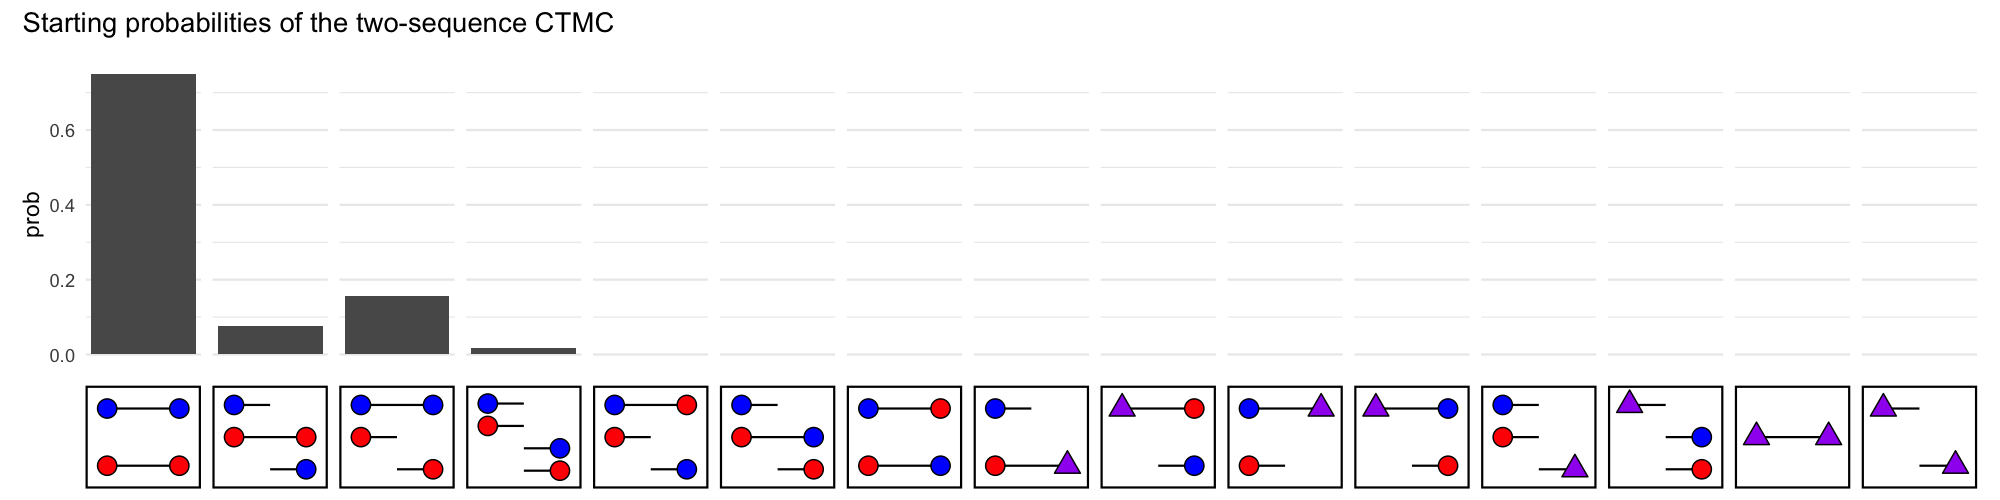

In [229]:
%%R -i pi_12 -i dat_12 -w 2000 -h 500 -r 150

library(patchwork)

p1 <- tibble(id = 0:14, prob = pi_12) %>% 
    ggplot() +
        geom_col(aes(id, prob)) +
        facet_wrap(~id, nrow = 1, scales = 'free_x')+
        theme_minimal() +
        theme(
            axis.title.x=element_blank(),
            axis.text.x=element_blank(),
            axis.ticks.x=element_blank(),
            strip.background = element_blank(),
            strip.text.x = element_blank(),
            panel.grid.major.x = element_blank(),
            panel.grid.minor.x = element_blank()

        )
p2 <- plot_states(dat_12)+
    facet_wrap(~id, scales = 'free', nrow = 1) +
    theme(
        strip.background = element_blank(),
        strip.text.x = element_blank()

    )

p1/p2 + 
    plot_layout(heights = c(3, 1)) +
    plot_annotation(
        title = 'Starting probabilities of the two-sequence CTMC'
)

We can now define a time interval (for example, 1), a coalescent rate (0.5) and a recombination rate (3) to get the distribution of states at a certain time:

In [219]:
t_12 = 1
coal_12 = 0.5
rho_12 = 3


trans_mat_12 = get_trans_mat(iter_lst_12, coal_12, rho_12)
final_12 = pi_12 @ expm(trans_mat_12*t_12)

array([0.01148455, 0.04921748, 0.05010538, 0.22336798, 0.03031674,
       0.03031674, 0.00464281, 0.03081025, 0.03081025, 0.03157308,
       0.03157308, 0.14469565, 0.14469565, 0.04120035, 0.14519001])

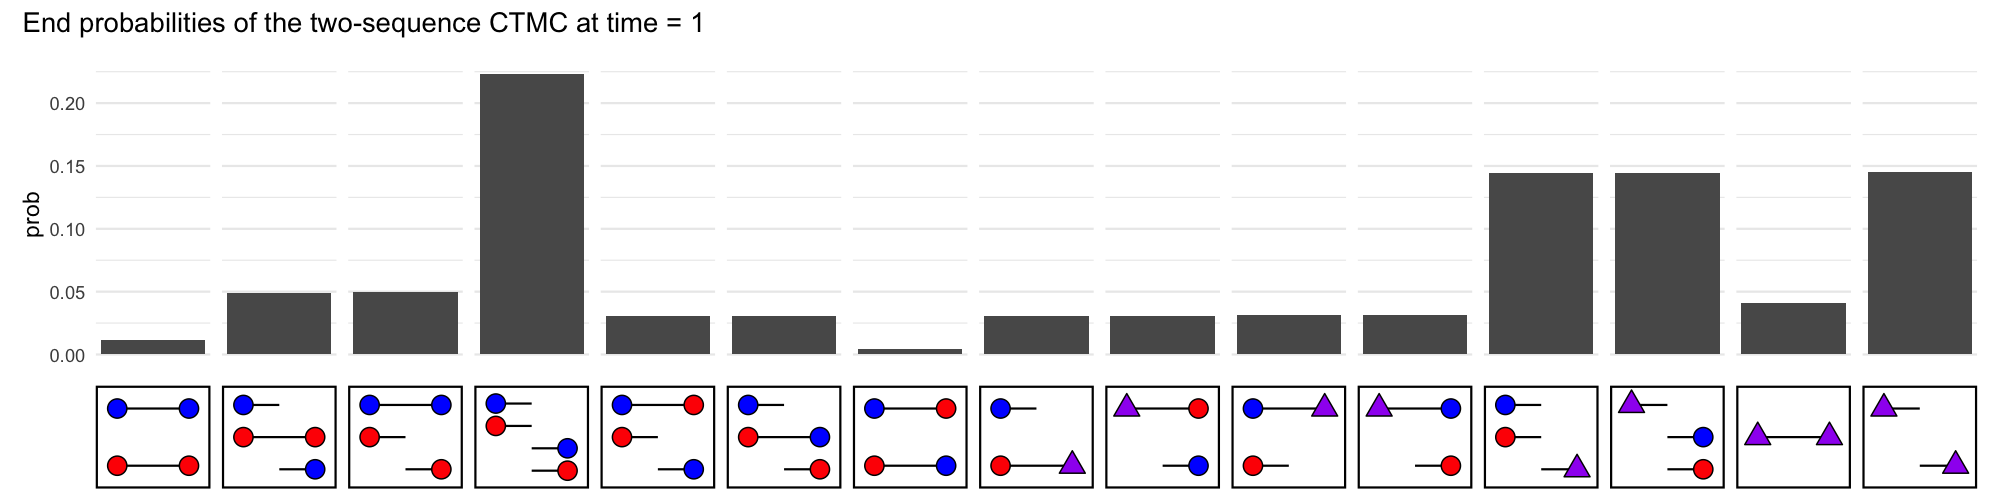

In [231]:
%%R -i final_12 -i dat_12 -w 2000 -h 500 -r 150

library(patchwork)

p1 <- tibble(id = 0:14, prob = final_12) %>% 
    ggplot() +
        geom_col(aes(id, prob)) +
        facet_wrap(~id, nrow = 1, scales = 'free_x')+
        theme_minimal() +
        theme(
            axis.title.x=element_blank(),
            axis.text.x=element_blank(),
            axis.ticks.x=element_blank(),
            strip.background = element_blank(),
            strip.text.x = element_blank(),
            panel.grid.major.x = element_blank(),
            panel.grid.minor.x = element_blank()

        )
p2 <- plot_states(dat_12)+
    facet_wrap(~id, scales = 'free', nrow = 1) +
    theme(
        strip.background = element_blank(),
        strip.text.x = element_blank()

    )

p1/p2 + plot_layout(heights = c(3, 1)) + 
    plot_layout(heights = c(3, 1)) +
    plot_annotation(
        title = 'End probabilities of the two-sequence CTMC at time = 1'
)

In [98]:
trans_mat_1 = get_trans_mat(iter_lst_1, coal=1, rho=2)
trans_mat_1

array([[-2.,  2.],
       [ 1., -1.]])

In [105]:
expm(trans_mat_1*0.1)

array([[0.82721215, 0.17278785],
       [0.08639393, 0.91360607]])

In [110]:
pi_2 = expm(trans_mat_1*0.1)[0]
pi_2

array([0.82721215, 0.17278785])

In [108]:
state_2 = [[(1, 1), (2, 2)]]
iter_lst_2 = get_states(state_2)
trans_mat_2 = get_trans_mat(iter_lst_2, coal=1, rho=2)


In [ ]:
state_3 = [[(0, 1), (0, 2), (0, 4), (1, 0), (2, 0), (4, 0)]]

iter_lst_3 = get_states(state_3)
len(iter_lst_3)

203

In [ ]:
trans_mat_3 = np.full((len(iter_lst_3), len(iter_lst_3)), '0')
for i in range(len(iter_lst_3)):
    new_lst = recombination(iter_lst_3[i])
    idx_lst = [iter_lst_3.index(j) for j in new_lst]
    for j in idx_lst:
        trans_mat_3[i,j]='R'
    new_lst = coalescent(iter_lst_3[i])
    idx_lst = [iter_lst_3.index(j) for j in new_lst]
    for j in idx_lst:
        trans_mat_3[i,j]='C'

In [11]:
trans_mat_3

array([['0', 'C', 'C', ..., '0', '0', '0'],
       ['R', '0', '0', ..., '0', '0', '0'],
       ['R', '0', '0', ..., '0', '0', '0'],
       ...,
       ['0', '0', '0', ..., '0', '0', 'C'],
       ['0', '0', '0', ..., '0', '0', 'C'],
       ['0', '0', '0', ..., '0', 'R', '0']], dtype='<U1')

In [12]:
%%R -i trans_mat_3 

library(tidyverse)

fun_trans <- function(x, coa, rho) {
    if (x == 'R') {
        return(rho)
    } else if (x == 'C') {
        return(coa)
    } else return(0)
}

set_coa_rho <- function(X, coa, rho) {
    
    dat = data.frame(lapply(X, Vectorize(fun_trans), coa = coa, rho = rho))
    dat = as.matrix(dat)
    dat <- matrix(as.numeric(dat),    # Convert to numeric matrix
                  ncol = ncol(X))
    dat[row(dat)==col(dat)] = -rowSums(dat)
    dat                                   
}

a <- set_coa_rho(trans_mat_3, 1, 2)




R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

R[write to console]: ✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.0.2     ✔ forcats 0.5.1

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [13]:
%%R

a[1:10, 1:10]

      [,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8] [,9] [,10]
 [1,]  -15    1    1    1    1    1    1    1    1     1
 [2,]    2  -12    0    0    0    0    0    0    0     0
 [3,]    2    0  -12    0    0    0    0    0    0     0
 [4,]    2    0    0  -12    0    0    0    0    0     0
 [5,]    2    0    0    0  -12    0    0    0    0     0
 [6,]    2    0    0    0    0  -12    0    0    0     0
 [7,]    2    0    0    0    0    0  -12    0    0     0
 [8,]    2    0    0    0    0    0    0  -12    0     0
 [9,]    2    0    0    0    0    0    0    0  -12     0
[10,]    2    0    0    0    0    0    0    0    0   -12


In [80]:
iter_lst_3[200]

[(0, 3), (7, 4)]

In [34]:
cutpoints_3_2 = []
for i in range(1, len(iter_lst_3)):
    if idx(iter_lst_3[i]) > idx(iter_lst_3[i-1]):
        cutpoints_3_2.append(i)
cutpoints_3_2

[34, 112, 183, 201]

-5

In [120]:
def get_indices(iter_lst_3, cutpoints_3_2, l, r, v, h):
    
    dct = {0:3, 1:3, 2:5, 3:6}
    
    if 0 not in [v, h]:
    
        # Starting states
        a = [[j for j in iter_lst_3[i] if 4 in j and 0 not in j and j != (4, 4)] for i in range(0, cutpoints_3_2[0])] 
        a = [i for i in range(len(a)) if len(a[i]) == 0]

        # No coalescence
        b = list(range(cutpoints_3_2[0]))

        if l != r:

            # 1st coalescent on min
            min_value = min([l, r])
            min_index = [l, r].index(min_value)
            c = [i for i in range(cutpoints_3_2[0], cutpoints_3_2[1]) if dct[[v, h][min_index]] in [j[min_index] for j in iter_lst_3[i]]]


            # No coalescence
            d = [i for i in range(cutpoints_3_2[1], cutpoints_3_2[2]) if 7 in [j[min_index] for j in iter_lst_3[i]]]
            d = c+d

            # 1st coalescent on max
            max_value = max([l, r])
            max_index = [l, r].index(max_value)
            e_min = [i for i in range(cutpoints_3_2[1], cutpoints_3_2[2]) if dct[[v, h][min_index]] in [j[min_index] for j in iter_lst_3[i]]]
            e_7_min = [i for i in range(cutpoints_3_2[2], cutpoints_3_2[3]) if 7 in [j[min_index] for j in iter_lst_3[i]]]
            e = [i for i in range(cutpoints_3_2[1], cutpoints_3_2[3]) if dct[[v, h][max_index]] in [j[max_index] for j in iter_lst_3[i]]]    
            seen = set()
            e = [x for x in e_min+e_7_min+e if x in seen or seen.add(x)]
        
        else:
            
            # Both coalesce
            c_l = [i for i in range(cutpoints_3_2[1], cutpoints_3_2[2]) if dct[v] in [j[0] for j in iter_lst_3[i]]]
            c_r = [i for i in range(cutpoints_3_2[1], cutpoints_3_2[2]) if dct[h] in [j[1] for j in iter_lst_3[i]]]
            seen = set()
            c = [x for x in c_l+c_r if x in seen or seen.add(x)]
            
            d = []
            e = []
    # else:
    #     
    #     if v == h:
    #         a_l = [i for i in range(cutpoints_3_2[1], cutpoints_3_2[2]) if 3 in [j[0] for j in iter_lst_3[i]]]
    #         a_r = [i for i in range(cutpoints_3_2[1], cutpoints_3_2[2]) if 3 in [j[1] for j in iter_lst_3[i]]]
    #         seen = set()
    #         a = [x for x in a_l+a_r if x in seen or seen.add(x)]
    #         
    #         b = []
    #         c = []
    #         d = []
    #         e = []
    #         
    #     else:
    #         if 
        
     
    return (a, b, c, d, e)

In [152]:
def calc_tm(nInt):
    return [0]+[-np.log(1-i/nInt) for i in range(1, nInt+1)]

In [153]:
a = calc_tm(4)
a

/var/folders/f2/kh1g9nkd125769chspqz3121r__05x/T/ipykernel_28718/2202113993.py:2: RuntimeWarning: divide by zero encountered in log
  return [0]+[-np.log(1-i/nInt) for i in range(1, nInt+1)]


[0, 0.2876820724517809, 0.6931471805599453, 1.3862943611198906, inf]

In [ ]:
expm(tm0[j]*rate_mat)[1,1:3]%*%
expm((tm[j]-tm0[j])*rate_mat)[1:3,4]*
exp(-(tm0[k]-tm[j]))*
# which is the same as 
# expm((tm0[k]-tm[j])*rate_mat)[4,4]*0.5*
(1-exp(-(tm[k]-tm0[k])))*0.5

In [168]:
def set_coa_rho(iter_lst_3, coa, rho):
    trans_mat_3 = np.full((len(iter_lst_3), len(iter_lst_3)), 0)
    for i in range(len(iter_lst_3)):
        new_lst = recombination(iter_lst_3[i])
        idx_lst = [iter_lst_3.index(j) for j in new_lst]
        for j in idx_lst:
            trans_mat_3[i,j]=rho
        new_lst = coalescent(iter_lst_3[i])
        idx_lst = [iter_lst_3.index(j) for j in new_lst]
        for j in idx_lst:
            trans_mat_3[i,j]=coa
    return trans_mat_3


rate_mat = set_coa_rho(iter_lst_3, 1, 2)

rate_mat

array([[0, 1, 1, ..., 0, 0, 0],
       [2, 0, 0, ..., 0, 0, 0],
       [2, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 2, 0]])

In [189]:
tm

[0, 0.6931471805599453, inf]

In [216]:
nInt = 3
tm = calc_tm(nInt)

rate_mat = set_coa_rho(iter_lst_3, 1, 3)

trans_mat = np.full((nInt*3, nInt*3), 0)
for l in range(1, nInt):
    for v in range(1, 4):
        for r in range(1, nInt):
            for h in range(1, 4):
                (a, b, c, d, e) = get_indices(iter_lst_3, cutpoints_3_2, l, r, v, h)
                if l < r:
                    mult_1 = expm(tm[l-1]*rate_mat)[np.ix_(a,b)]
                    mult_2 = expm((tm[l]-tm[l-1])*rate_mat)[np.ix_(b,c)]
                    mult_3 = expm((tm[r-1]-tm[l])*rate_mat)[np.ix_(c,d)]
                    mult_4 = expm((tm[r]-tm[r-1])*rate_mat)[np.ix_(d,e)]
                    trans_mat[(l-1)*3+(v-1), (r-1)*3+(h-1)] = np.sum(mult_1@mult_2@mult_3@mult_4)
                elif l > r:
                    mult_1 = expm(tm[r-1]*rate_mat)[np.ix_(a,b)]
                    mult_2 = expm((tm[r]-tm[r-1])*rate_mat)[np.ix_(b,c)]
                    mult_3 = expm((tm[l-1]-tm[r])*rate_mat)[np.ix_(c,d)]
                    mult_4 = expm((tm[l]-tm[l-1])*rate_mat)[np.ix_(d,e)]
                    trans_mat[(l-1)*3+(v-1), (r-1)*3+(h-1)] = np.sum(mult_1@mult_2@mult_3@mult_4)
                elif l == r:
                    mult_1 = expm(tm[l-1]*rate_mat)[np.ix_(a,b)]
                    mult_2 = expm((tm[l]-tm[l-1])*rate_mat)[np.ix_(b,c)]
                    trans_mat[(l-1)*3+(v-1), (r-1)*3+(h-1)] = np.sum(mult_1@mult_2)

/var/folders/f2/kh1g9nkd125769chspqz3121r__05x/T/ipykernel_28718/2202113993.py:2: RuntimeWarning: divide by zero encountered in log
  return [0]+[-np.log(1-i/nInt) for i in range(1, nInt+1)]


In [217]:
trans_mat

array([[  28,   18,   18, 1721, 1711, 1711,    0,    0,    0],
       [  18,   23,   23, 1721, 1729, 1729,    0,    0,    0],
       [  18,   23,   23, 1721, 1729, 1729,    0,    0,    0],
       [1721, 1721, 1721, 7371, 7011, 7011,    0,    0,    0],
       [1711, 1729, 1729, 7011, 7196, 7196,    0,    0,    0],
       [1711, 1729, 1729, 7011, 7196, 7196,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0]])